# Working with mplstereonet

mplstereonet is a python package that allows you to make stereonets in matplotlib. There recent change in numpy to version 1.2 depreciated a method mplstereonet uses. We need to specify an older version of numpy (numpy=1.) until mplstereonet is updated. 

In [11]:
import mplstereonet as mps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fractoolbox as ftb

## Introduction to mplstereonet

Note that mplstereonet does not work with the latest version of numpy due to the depreciation of a method. This issue is being worked on. Your requirements file specifies the latest version of numpy that is compatible with mplstereonet.

In [3]:
strike = 10 # strike of the plane
dip = 85 # dip of the plane

inclination = 30 # inclination of the well
azimuth = 90  # azimuth of the well

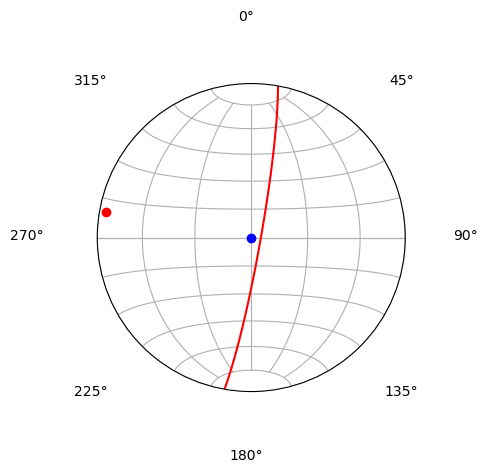

In [4]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip, c='r', label='Plane')
ax.pole(strike, dip, c='r')
ax.line(azimuth, inclination, c='b', label='Well')
ax.grid(True)

# The default is a lower hemisphere Schmidt net, but other types are available

## 0. Import data and define constants

In [7]:
picks = pd.read_csv('1_Pre-processed data.csv')
beds = picks[(picks['type'] == 'Bed boundary')].copy()
fractures = picks[(picks['type'] == 'Conductive, HC') | (picks['type'] == 'Conductive, LC')].copy()
mudlog = pd.read_csv('1_pre-processed mudlog.csv')

# these imports and boolean statements are from the second notebook, 
# so we have not included the usual checks

In [8]:
top_m = picks['depth_m'].min() - 1
bot_m = picks['depth_m'].max() + 1

In [9]:
# vertical well
well_azimuth = 0
well_inclination = 0

In [10]:
# define a lithology color palette

color_dict = dict({
    'Rock A': 'tab:blue',
    'Rock B': 'tab:green',
})

### 1. Create and plot isogenic contours

In [12]:
help(ftb.isogeniccontour)

Help on function isogeniccontour in module fractoolbox.geometric_bias:

isogeniccontour(wpl, waz, sin_al)
    Parametrically calculates isogenic contours based on well path
    
    Args:
        wpl: Well plunge (0-90 degrees) which is the inclination of the
            well path measured from a horizontal surface
            
            Suggestion: If the well deviation is relativity consistent, 
                calculate the mean deviation magnitude (drillers dip) and 
                subtract this angle from 90 to find the plunge. If there
                are large variations in well geometry, then fracture data
                may need to be split onto separate stereonets, each with a
                set of isogenic contours calculated using that section's 
                mean well deviation. 
    
        waz: Well azimuth (0-360 degrees) which is the map direction
            the well is deviated in
    
            Suggestion: If the well azimuth is relativity consistent,
   

In [13]:
# contour intervals
# 0.2 & 0.1 excluded so the blind zone is visible
contours = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0] 

# use fractoolbox to calculate the strike and dip of the isogenic contours
# the strike/dip lists are plotted as poles to plane on a stereonet to generate contours
iso_strike = []
iso_dip = []
for contour in contours:
    strike, dip = ftb.isogeniccontour(
        90 - well_inclination, # convert inclination to plunge
        well_azimuth, 
        contour
        )
    iso_strike.append(strike)
    iso_dip.append(dip)

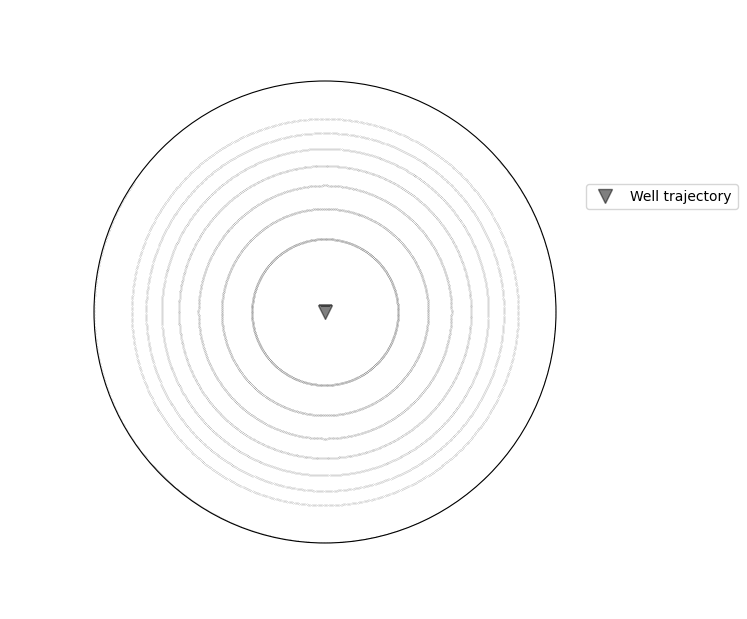

In [18]:
# contour lines are slow to plot because they have many points
# I am working on optimizing this method

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111, projection='equal_area_stereonet')

ax.pole(
    iso_strike,iso_dip,
    '.',
    markersize=0.1,
    color='k',
)

ax.line(
    90 - well_inclination, 
    well_azimuth,
    marker ='v',
    color='k',
    markersize=10,
    alpha = 0.5,
    label = 'Well trajectory'
)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.75), 
    ncol=1,
)

ax.set_azimuth_ticks([]);


### 2. Plot picks shaped by type and colored by lithology

In [26]:
# filter picks dataframe to only include the fractures
fractures_HC = picks[(picks['type'] == 'Conductive, HC')].copy()
fractures_LC = picks[(picks['type'] == 'Conductive, LC')].copy()

# filter picks dataframe to only include the bed boundaries
beds = picks[(picks['type'] == 'Bed boundary')].copy()

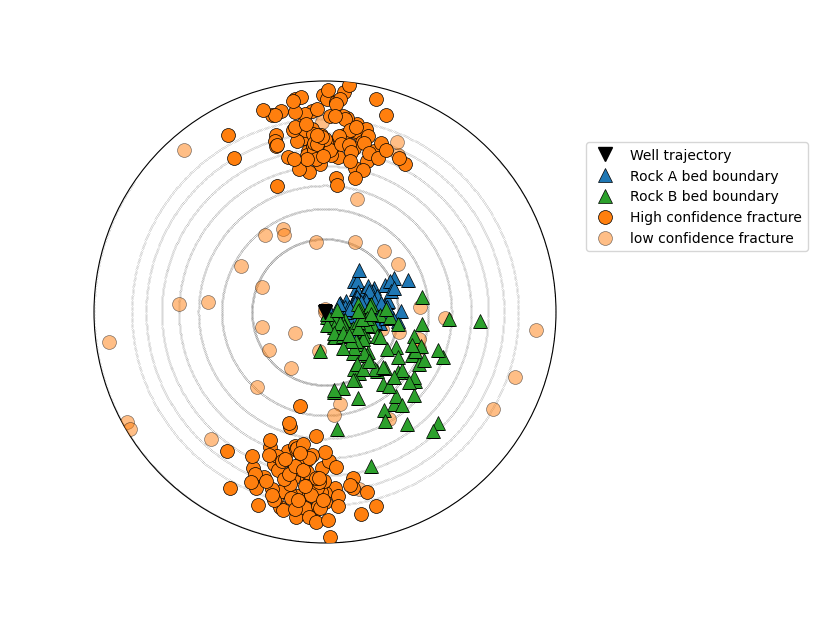

In [52]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='equal_area_stereonet')

ax.pole(
    iso_strike,
    iso_dip,
    '.',
    markersize=0.1,
    color='k',
)

ax.line(
    90 - well_inclination, # convert to plunge
    well_azimuth,
    marker ='v',
    color='k',
    markersize=10,
    label = 'Well trajectory',
    zorder=13,
)


for lithology in color_dict.keys():
    ax.pole(
        beds[beds['lithology'] == lithology]['strike'],
        beds[beds['lithology'] == lithology]['dip'],
        '^',
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=0.5,
        color=color_dict[lithology],
        label=f'{lithology} bed boundary',
        zorder=12,
    )

ax.pole(
    fractures_HC['strike'],
    fractures_HC['dip'],
    'o',
    markersize=10,
    markeredgecolor='k',
    markeredgewidth=0.5,
    color='tab:orange',
    label='High confidence fracture',
    zorder=11,
)

ax.pole(
    fractures_LC['strike'],
    fractures_LC['dip'],
    'o',
    markersize=10,
    markeredgecolor='k',
    markeredgewidth=0.5,
    color='tab:orange',
    alpha=0.5,
    label='low confidence fracture',
    zorder=10,
)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.75), 
    ncol=1,
)

ax.set_azimuth_ticks([]);


### 3. Plot fractures sized by apparent aperture

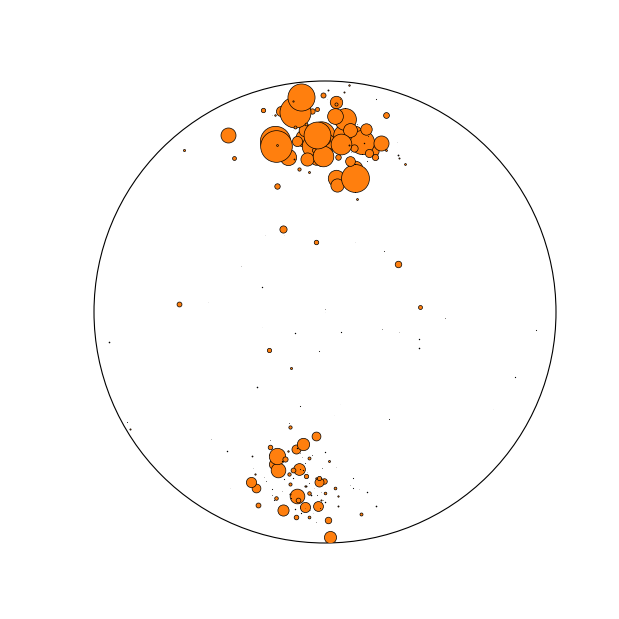

In [49]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='equal_area_stereonet')

for strike, dip, aperture in zip(fractures_HC['strike'], fractures_HC['dip'], fractures_HC['aperture_mm']):
    ax.pole(
        strike,
        dip,
        'o',
        markersize=aperture * 1.2,
        markeredgecolor='k',
        markeredgewidth=0.5,
        color='tab:orange',
        zorder=11,
    )

for strike, dip, aperture in zip(fractures_LC['strike'], fractures_LC['dip'], fractures_LC['aperture_mm']):
    ax.pole(
        strike,
        dip,
        'o',
        markersize=aperture * 1.2,
        markeredgecolor='k',
        markeredgewidth=0.5,
        color='tab:orange',
        zorder=11,
    )

ax.set_azimuth_ticks([]);
